In [1]:
from typing import List
from tqdm import tqdm
from dataclasses import asdict
import pandas as pd

import matplotlib.pyplot as plt


import torch

from chinese_checkers.simulation.GameSimulation import GameSimulation
from chinese_checkers.model.BootstrapModel import BootstrapModel
from chinese_checkers.experience import ExperienceData, ExperienceCatalog, ExperienceMetadata

from chinese_checkers.cnn import CnnEncoderState, CnnEncoderMove, DqlCnnAgent, DqlCnnModel

print("CUDA Available:", torch.cuda.is_available())

def print_err(error_values):
    epochs = [entry['epoch'] for entry in error_values]
    test_errors = [entry['test_error'] for entry in error_values]
    validation_errors = [entry['validation_error'] for entry in error_values]
    validation_errors_discounted = [entry['validation_error_discounted_returns'] for entry in error_values]
    
    # Plotting the lines with different styles
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, test_errors, label='Test Error', linestyle=':', marker='o')
    plt.plot(epochs, validation_errors, label='Validation Error', linestyle='--')
    plt.plot(epochs, validation_errors_discounted, label='Validation Error (Discounted Returns)', linestyle='-')
    
    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Error Value')
    plt.title('Error Values over Epochs')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'training-error-{model_version}.png')
    plt.show()

CUDA Available: True


In [2]:
generator_name="CnnExperienceEncoder-v005"

catalog = ExperienceCatalog()
dataset_metadata: List[ExperienceMetadata] = catalog.list_datasets()
pd.DataFrame([asdict(m) for m in dataset_metadata if m.generator_name == generator_name])

,player_count,board_size,max_game_length,winning_player,name,version,generator_name,current_player
0,2,4,1000,0,bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,0
1,2,4,1000,0,bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,3
2,2,4,1000,3,bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,0
3,2,4,1000,3,bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,3
4,2,4,1000,0,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,0
5,2,4,1000,0,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,3
6,2,4,1000,3,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,0
7,2,4,1000,3,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,3
8,2,4,1000,0,bootstrap-simulation-p0d15,v0.0.1,CnnExperienceEncoder-v005,0
9,2,4,1000,0,bootstrap-simulation-p0d15,v0.0.1,CnnExperienceEncoder-v005,3


In [3]:
player_count = 2
current_player = "0"
board_size = 4

In [4]:
# Initialize tqdm with detailed postfix for metadata info
experiences: List[ExperienceData] = []
progress_bar = tqdm(dataset_metadata, desc="Loading datasets")

for metadata in progress_bar:
    # Dynamically set postfix with metadata name and generator name
    progress_bar.set_postfix(name=metadata.name, generator=metadata.generator_name)

    if (
        metadata.player_count == str(player_count)
        and metadata.current_player == current_player
        and metadata.generator_name == generator_name
        and metadata.board_size == str(board_size)
    ):
        experiences.extend(catalog.load_dataset(metadata))

print(f"Found {len(experiences)} datasets for player_count: {player_count}, and current_player: {current_player}.")

Loading datasets: 100%|██████████| 205/205 [01:31<00:00,  2.23it/s, generator=CnnExperienceEncoder-v005, name=bootstrap-0d01-vs-dql-v004]             

Found 157792 datasets for player_count: 2, and current_player: 0.


In [5]:
from collections import defaultdict

def limit_duplicates(experiences, max_count):
    # Dictionary to count occurrences
    occurrence_count = defaultdict(int)
    
    # List to hold filtered experiences
    filtered_experiences = []
    
    for experience in experiences:
        # Only add experience if it hasn't reached the max_count
        if occurrence_count[experience.action_hash()] < max_count:
            filtered_experiences.append(experience)
            occurrence_count[experience.action_hash()] += 1
            
    return filtered_experiences
max_count = 1
filtered_experiences = limit_duplicates(experiences, max_count)
print(f"Found {len(filtered_experiences)} experiences after removing duplicates with limit {max_count}")

Found 157792 experiences after removing duplicates with limit 1


In [6]:
len(limit_duplicates([experiences[0], experiences[0]], 1))

1

In [8]:
p0_win_count = len([e for e in experiences if e.metadata.winning_player =="0"])
p3_win_count = len([e for e in experiences if e.metadata.winning_player =="3"])
no_win_count = len([e for e in experiences if not e.metadata.winning_player in ["0", "3"]])

print(f"p0_win_count {p0_win_count}, p3_win_count {p3_win_count}, no_win_count {no_win_count}")

p0_win_count 55427, p3_win_count 87966, no_win_count 14399


In [9]:
# [e for e in experiences if e.metadata.winning_player =="3"][0].data

In [10]:
state_encoder = CnnEncoderState(board_size)
move_encoder = CnnEncoderMove(board_size)
model_version = "v005"
# Define model parameters
gamma = 0.99
lr = 0.0001
batch_size = 2**9
model_save_path = f"dql_cnn_model_{model_version}.pth"

Starting training...


Training Progress:   0%|          | 0/20 [06:04<?, ?it/s, Test Error=0.6303, Validation Error=0.6342, Validation Error (Discounted)=66.5962]

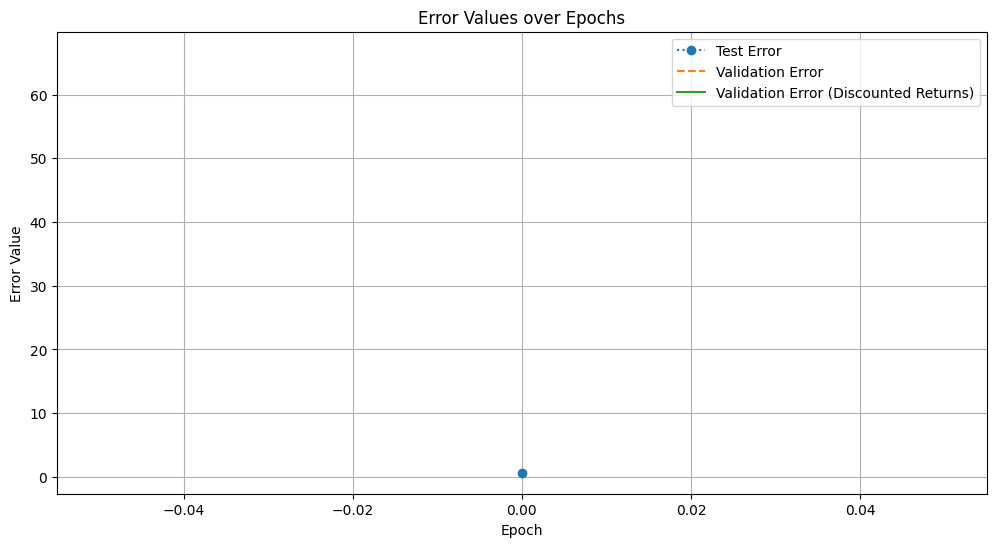

Training Progress:   5%|▌         | 1/20 [12:11<1:55:30, 364.76s/it, Test Error=2.3543, Validation Error=2.3610, Validation Error (Discounted)=55.0754]

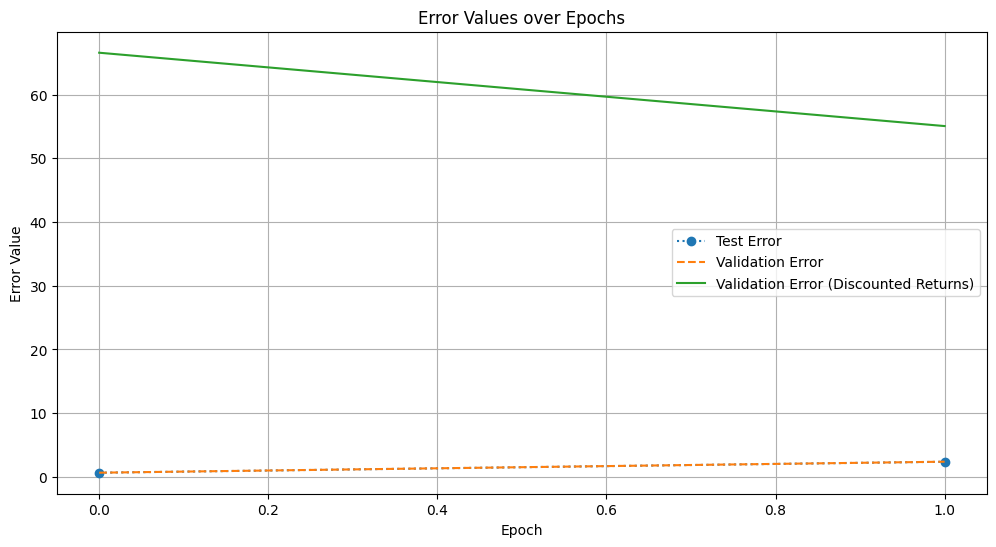

Training Progress:  10%|█         | 2/20 [18:14<1:49:46, 365.90s/it, Test Error=4.1121, Validation Error=4.1206, Validation Error (Discounted)=48.1009]

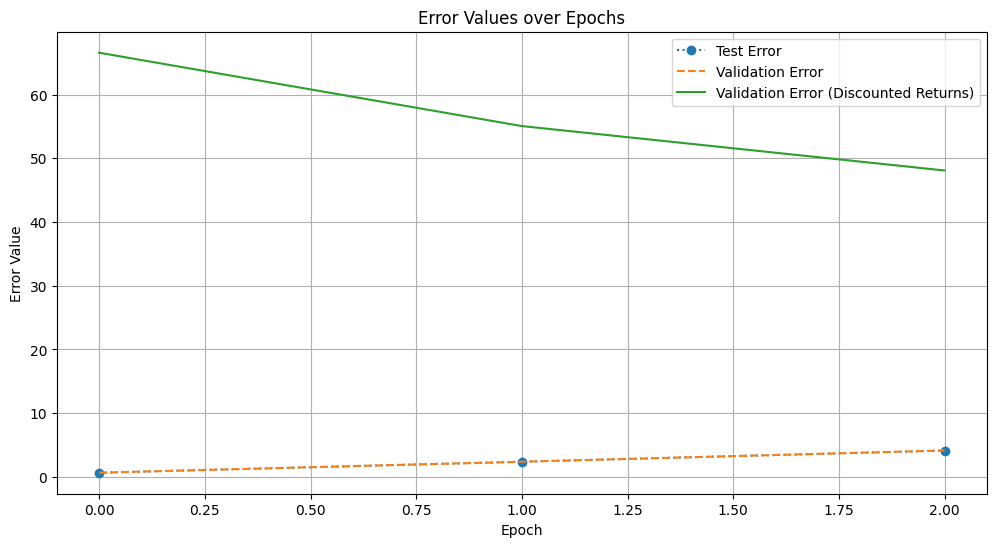

Training Progress:  15%|█▌        | 3/20 [24:20<1:43:22, 364.84s/it, Test Error=4.9667, Validation Error=4.9762, Validation Error (Discounted)=46.0952]

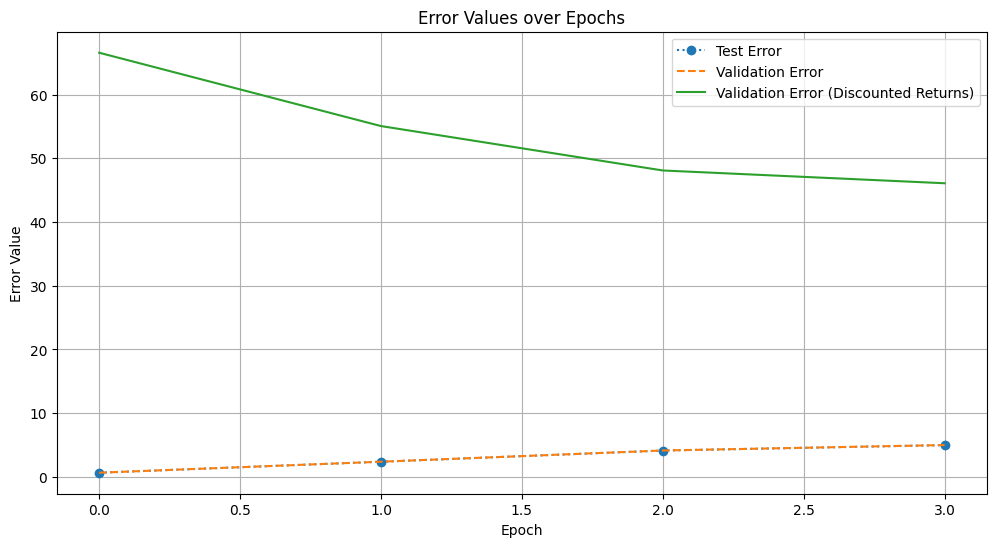

Training Progress:  20%|██        | 4/20 [30:23<1:37:21, 365.12s/it, Test Error=4.3550, Validation Error=4.3643, Validation Error (Discounted)=48.8305]

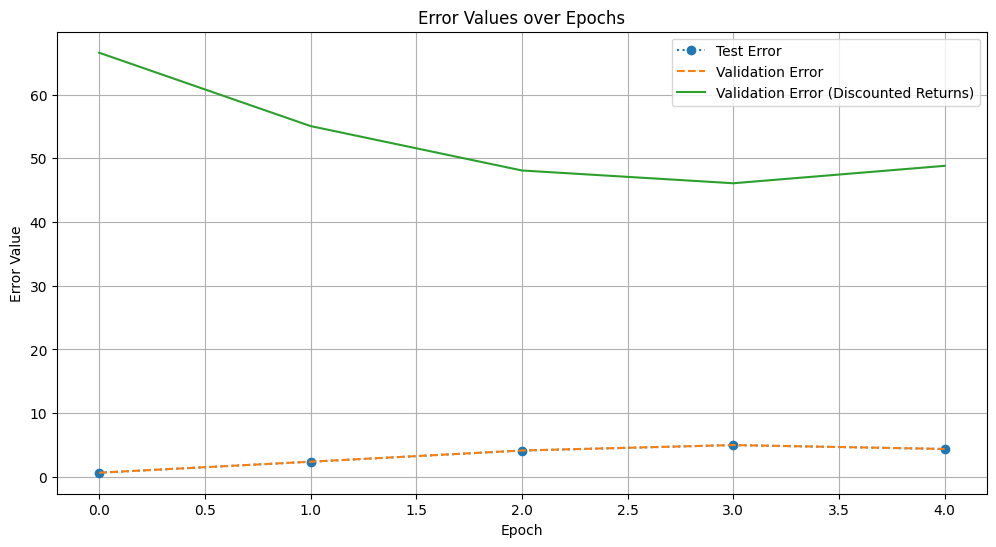

Training Progress:  25%|██▌       | 5/20 [36:22<1:31:03, 364.26s/it, Test Error=3.6414, Validation Error=3.6505, Validation Error (Discounted)=50.2439]

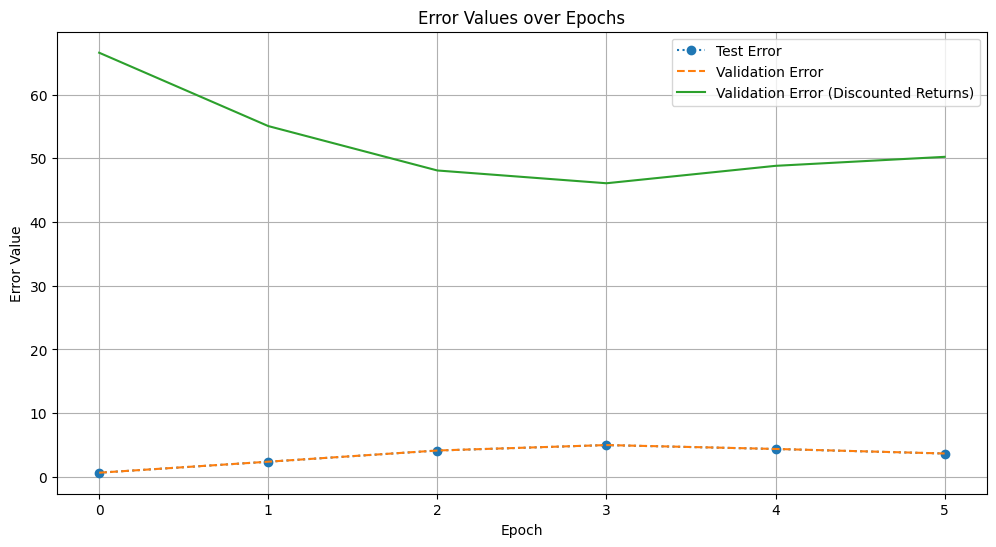

Training Progress:  30%|███       | 6/20 [42:39<1:24:34, 362.45s/it, Test Error=2.7642, Validation Error=2.7725, Validation Error (Discounted)=53.1838]

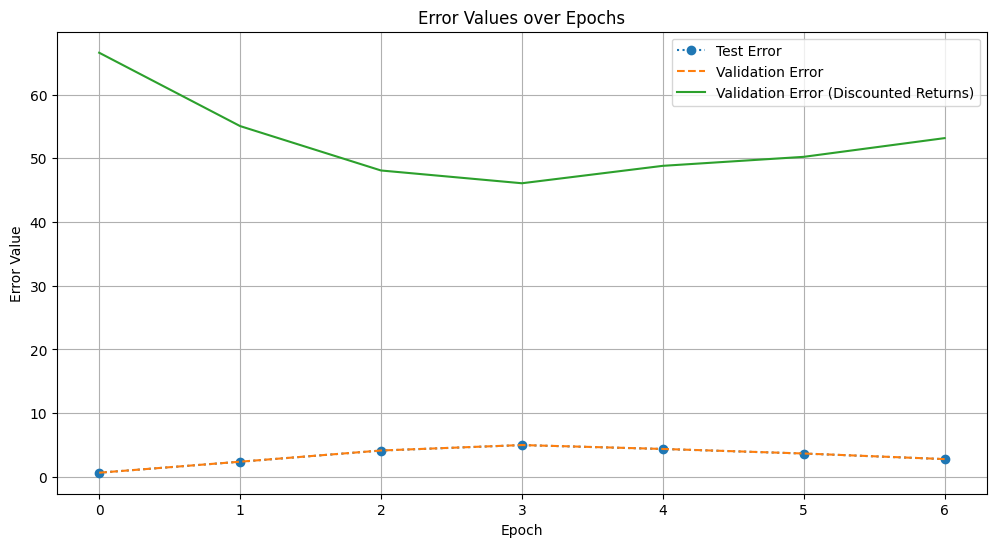

Training Progress:  35%|███▌      | 7/20 [48:48<1:19:34, 367.25s/it, Test Error=3.2682, Validation Error=3.2781, Validation Error (Discounted)=52.2585]

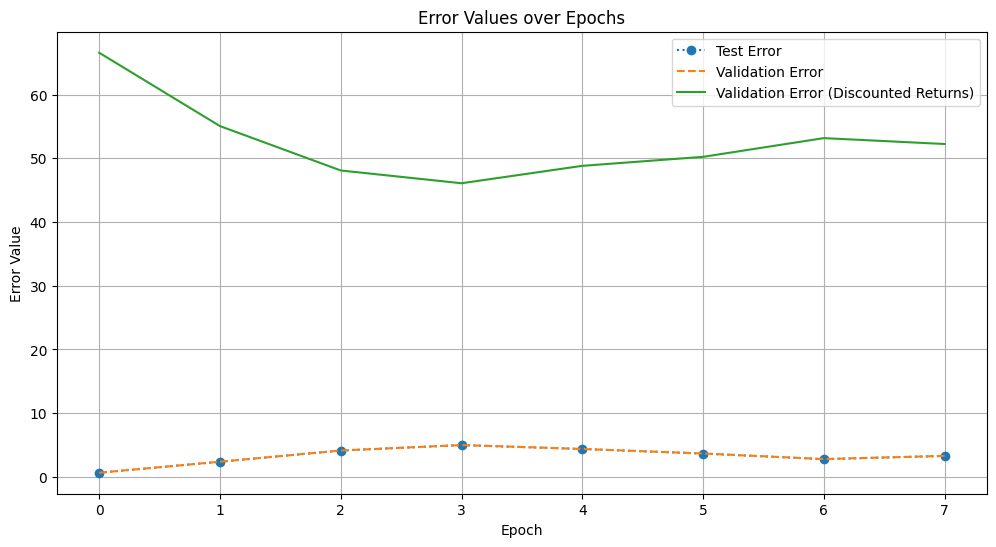

Training Progress:  40%|████      | 8/20 [54:50<1:13:33, 367.80s/it, Test Error=9.4489, Validation Error=9.4688, Validation Error (Discounted)=37.5358]

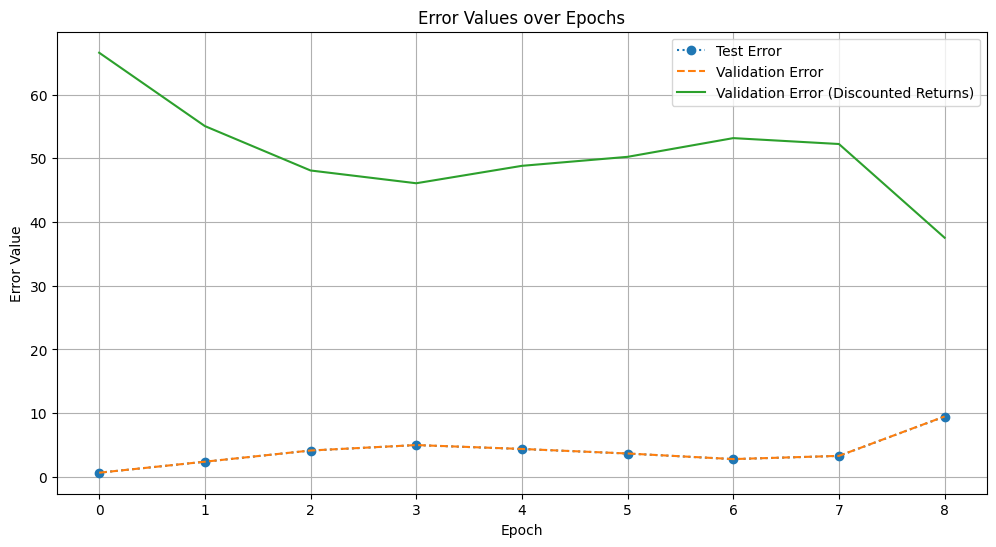

Training Progress:  45%|████▌     | 9/20 [1:00:59<1:07:08, 366.25s/it, Test Error=30.5148, Validation Error=30.5546, Validation Error (Discounted)=22.3290]

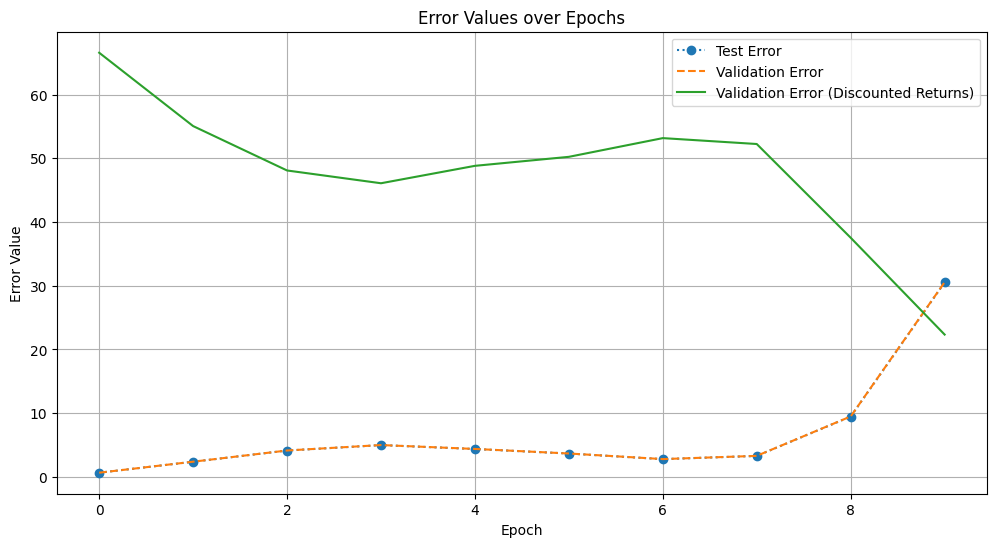

Training Progress:  50%|█████     | 10/20 [1:00:59<1:01:09, 366.99s/it, Test Error=30.5148, Validation Error=30.5546, Validation Error (Discounted)=22.3290]

In [ ]:
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets (80/20 split)
experience_datas = [e.data for e in experiences]
train_experiences, test_experiences = train_test_split(experience_datas, test_size=0.2, random_state=42)

# Initialize the agent
agent = DqlCnnAgent(
    state_encoder=state_encoder,
    move_encoder=move_encoder,
    gamma=gamma,
    lr=lr,
    batch_size=batch_size
)

# List to store error metrics from each epoch
error_values = []

# Training loop with validation at each epoch
print("Starting training...")
num_epochs = 20
with tqdm(range(num_epochs), desc="Training Progress") as epoch_bar:
    for epoch in epoch_bar:
        # Shuffle training data each epoch for better generalization
        random.shuffle(train_experiences)
        
        # Training phase
        for i in range(0, len(train_experiences), batch_size):
            batch_experiences = train_experiences[i:i + batch_size]
            for experience in batch_experiences:
                agent.store_experience(experience)  # Store each experience in the batch
            agent.train()  # Train on the batch

        # Validation phase
        results = agent.validate(test_set=test_experiences, validation_set=train_experiences)
        
        # Append validation results to error_values list
        error_values.append({
            "epoch": epoch,
            "test_error": results['test_error'],
            "validation_error": results['validation_error'],
            "validation_error_discounted_returns": results['validation_error_discounted_returns']
        })
        
        # Update progress bar with current errors
        epoch_bar.set_postfix({
            "Test Error": f"{results['test_error']:.4f}",
            "Validation Error": f"{results['validation_error']:.4f}",
            "Validation Error (Discounted)": f"{results['validation_error_discounted_returns']:.4f}"
        })
        
        # Save the model at each epoch
        agent.save(model_save_path)
        print_err(error_values)

# Save the trained model with all components
print(f"Model and components saved to {model_save_path}")


---

dql_cnn_model_v003.pth
Training Progress: 100%|██████████| 120/120 [19:31:46<00:00, 585.89s/it, Test Error=17.5490, Validation Error=17.5443, Validation Error (Discounted)=538.4413]

---



In [ ]:
# model_1 = BootstrapModel()
model_1 = DqlCnnModel(
    model_path=model_save_path,                          
    board_size=4                               
)

# model_2 = DqlCnnModel(
#     model_path=model_save_path,                          
#     board_size=4                               
# )
model_2 = BootstrapModel()


# Simulate the game using the models
game_simulation = GameSimulation.simulate_game(
    models=[model_1, model_2],  # DQL model plays against the bootstrap model
    name=f"dql_cnn_vs_bootstrap_{model_version}_simulation",
    version="v1.0.0",
    print_period=500,
    show_coordinates=True,
    max_turns=1000
)


In [ ]:
game_simulation.save_animation()

In [ ]:
game_sequence = game_simulation._to_game_sequence()
for i, (move, game) in enumerate(zip(game_simulation.data.historical_moves, game_sequence)):
    print(f"\nCurrent Player: {game.get_current_player().player_id} \n{move}\nTurn: {i}")
    game.print()
    if i > 20:
        break